In [1]:
data_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks"

IO_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-IO"
# 0 to 19 trailel
VR_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-VR"
# 0 to 12 trailel
VV_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-VV"
# 0 to 12 trailel

Data_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-IO/S00_data.csv"
Labels_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-IO/S00_labels.csv"


In [2]:
# ==============================
# 📚 جميع المكتبات المطلوبة
# ==============================

# التعامل مع الملفات والبيانات
import os               # للتعامل مع الملفات والمجلدات
import csv              # قراءة ملفات CSV
import numpy as np      # المصفوفات وعمليات الحساب
import random           # توليد نوافذ عشوائية أو shuffle

# معالجة الإشارات (Signal Processing)
from scipy.signal import butter, lfilter   # تطبيق فلتر Low-pass / High-pass

# بناء الشبكات العصبية (Deep Learning)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# تقييم الأداء وVisualization
import matplotlib.pyplot as plt                      # رسم الإشارات والنتائج
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# تحسين وتحميل البيانات
from sklearn.utils import shuffle                    # لخلط البيانات قبل التدريب

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [3]:
def decode_stim(data_path, file_stim):
    """
    قراءة ملف الـ labels واستخراج:
    - corrupt intervals (الفترات الفاسدة)
    - blinks (أوقات الرمشات)
    """
    interval_corrupt = []
    blinks = []
    n_corrupt = 0

    with open(os.path.join(data_path, file_stim)) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            if row[0] == "corrupt":
                n_corrupt = int(row[1])
            elif n_corrupt > 0:
                if float(row[1]) == -1:
                    t_end = -1  # until end
                else:
                    t_end = float(row[1])
                interval_corrupt.append([float(row[0]), t_end])
                n_corrupt = n_corrupt - 1
            elif row[0] == "blinks":
                # check that n_corrupt is 0
                if not n_corrupt == 0:
                    print("!Error in parsing")
            else:
                blinks.append([float(row[0]), int(row[1])])

    blinks = np.array(blinks)
    return interval_corrupt, blinks

In [4]:
fs = 250.0  # Sampling frequency

def load_full_dataset(folder_path):
    """
    Reads all *_data.csv and *_labels.csv files in the folder
    Supports EEG-IO, EEG-MB, EEG-VR, EEG-VV
    Returns:
        all_data: list of numpy arrays (each subject's data)
        all_blinks: list of lists (blink labels per subject)
        all_intervals: list of intervals per subject
        all_subject_names: list of subject names
    """

    data_files = sorted([f for f in os.listdir(folder_path) if '_data' in f])

    all_data = []
    all_blinks = []
    all_intervals = []
    all_subject_names = []

    for data_file in data_files:
        label_file = data_file.replace('_data', '_labels')
        data_path = os.path.join(folder_path, data_file)

        print(f"\nProcessing: {data_file}")

        # ----- Load data according to dataset type -----
        if folder_path.endswith('EEG-IO') or folder_path.endswith('EEG-MB'):
            data_sig = np.loadtxt(data_path, delimiter=";", skiprows=1, usecols=(0,1,2))
        elif folder_path.endswith('EEG-VR') or folder_path.endswith('EEG-VV'):
            data_sig = np.loadtxt(data_path, delimiter=",", skiprows=5, usecols=(0,1,2))
            data_sig = data_sig[0:(int(200*fs)+1), :]
            data_sig = data_sig[:, 0:3]
            data_sig[:,0] = np.arange(0, len(data_sig)) / fs
        else:
            raise ValueError("Unknown dataset folder. Supported: EEG-IO, EEG-MB, EEG-VR, EEG-VV")

        # ----- Load labels -----
        intervals, blinks = decode_stim(folder_path, label_file)

        # ----- Store -----
        all_data.append(data_sig)
        all_blinks.append(blinks)
        all_intervals.append(intervals)
        all_subject_names.append(data_file.replace("_data.csv",""))

        print(f"  - Data shape: {data_sig.shape}")
        print(f"  - Blinks: {len(blinks)}")
        print(f"  - Corrupt intervals: {len(intervals)}")

    print("\n✅ Finished loading all dataset!")
    return all_data, all_blinks, all_intervals, all_subject_names

In [5]:
print("="*60)
print("LOADING EEG-IO DATASET")
print("="*60)
IO_all_data, IO_all_blinks, IO_all_intervals, IO_all_subject_names = load_full_dataset(IO_path)

print("\n" + "="*60)
print("LOADING EEG-VR DATASET")
print("="*60)
VR_all_data, VR_all_blinks, VR_all_intervals, VR_all_subject_names = load_full_dataset(VR_path)

print("\n" + "="*60)
print("LOADING EEG-VV DATASET")
print("="*60)
VV_all_data, VV_all_blinks, VV_all_intervals, VV_all_subject_names = load_full_dataset(VV_path)

print("\n" + "="*60)
print("📊 DATASET SUMMARY")
print("="*60)
print(f"IO subjects: {len(IO_all_data)}")
print(f"VR subjects: {len(VR_all_data)}")
print(f"VV subjects: {len(VV_all_data)}")
print(f"Total subjects: {len(IO_all_data) + len(VR_all_data) + len(VV_all_data)}")

LOADING EEG-IO DATASET

Processing: S00_data.csv
  - Data shape: (25568, 3)
  - Blinks: 25
  - Corrupt intervals: 1

Processing: S01_data.csv
  - Data shape: (25568, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S02_data.csv
  - Data shape: (25568, 3)
  - Blinks: 25
  - Corrupt intervals: 0

Processing: S03_data.csv
  - Data shape: (25568, 3)
  - Blinks: 26
  - Corrupt intervals: 1

Processing: S04_data.csv
  - Data shape: (25536, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S05_data.csv
  - Data shape: (25568, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S06_data.csv
  - Data shape: (19328, 3)
  - Blinks: 27
  - Corrupt intervals: 0

Processing: S07_data.csv
  - Data shape: (25696, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S08_data.csv
  - Data shape: (25664, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S09_data.csv
  - Data shape: (25696, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S10_data.csv
  - Data shape: (2566

In [6]:
# Positive: Startle Blinks (code=1) من IO فقط
positive_blinks = []

for i, blinks in enumerate(IO_all_blinks):
    startle_idx = np.where(blinks[:,1] == 1)[0]
    positive_blinks.extend([ (i, idx) for idx in startle_idx ])

print(f"✅ Total positive samples (startle blinks): {len(positive_blinks)}")

✅ Total positive samples (startle blinks): 472


In [7]:
def get_safe_negative_windows(data, blinks, n_windows, fs=250, window_size=250, min_distance_sec=0.8):
    """
    اختيار نوافذ negative بعيدة عن أي blink

    Parameters:
    -----------
    data: numpy array - بيانات EEG
    blinks: numpy array - أوقات الـ blinks [time, code]
    n_windows: int - عدد النوافذ المطلوبة
    fs: float - sampling frequency (250 Hz)
    window_size: int - حجم النافذة (250 samples = 1 sec)
    min_distance_sec: float - المسافة الآمنة من أي blink (بالثواني)

    Returns:
    --------
    list of safe window indices
    """
    safe_windows = []
    blink_times = blinks[:, 0]  # أوقات كل الـ blinks بالثواني

    max_idx = data.shape[0] - window_size
    attempts = 0
    max_attempts = n_windows * 100

    while len(safe_windows) < n_windows and attempts < max_attempts:
        # اختيار index عشوائي
        idx = random.randint(0, max_idx)
        time_sec = idx / fs

        # التأكد إن النافذة بعيدة عن كل الـ blinks
        distances = np.abs(blink_times - time_sec)

        if np.min(distances) > min_distance_sec:
            if idx not in safe_windows:  # تجنب التكرار
                safe_windows.append(idx)

        attempts += 1

    # لو لسه مش كفاية، نقلل المسافة تدريجياً
    if len(safe_windows) < n_windows:
        reduced_distance = min_distance_sec * 0.6  # نقلل لـ 60%

        while len(safe_windows) < n_windows and attempts < max_attempts * 2:
            idx = random.randint(0, max_idx)
            time_sec = idx / fs
            distances = np.abs(blink_times - time_sec)

            if np.min(distances) > reduced_distance:
                if idx not in safe_windows:
                    safe_windows.append(idx)

            attempts += 1

    return safe_windows

In [8]:
# Negative windows strategy:
# 1. نوافذ آمنة من IO
# 2. نوافذ آمنة من VR
# 3. نوافذ آمنة من VV

negative_windows = []

# ====== من IO ======
print("="*60)
print("🔍 Generating negative windows from IO...")
print("="*60)
for i, data in enumerate(IO_all_data):
    n_windows = len(IO_all_blinks[i]) // 2  # نصف العدد من IO
    print(f"Subject {IO_all_subject_names[i]}: ", end="")

    safe_idx = get_safe_negative_windows(
        data=data,
        blinks=IO_all_blinks[i],
        n_windows=n_windows,
        fs=250,
        window_size=250,
        min_distance_sec=0.8
    )

    print(f"Found {len(safe_idx)}/{n_windows} windows")
    negative_windows.extend([ (i, idx) for idx in safe_idx ])

print(f"\n✅ From IO: {len(negative_windows)} windows")

# ====== من VR ======
print("\n" + "="*60)
print("🔍 Generating negative windows from VR...")
print("="*60)
vr_negative = []
for i, data in enumerate(VR_all_data):
    blinks = VR_all_blinks[i]
    n_windows = max(len(blinks) // 3, 5)  # على الأقل 5 نوافذ
    print(f"Subject {VR_all_subject_names[i]}: ", end="")

    safe_idx = get_safe_negative_windows(
        data=data,
        blinks=blinks,
        n_windows=n_windows,
        fs=250,
        window_size=250,
        min_distance_sec=0.8
    )

    print(f"Found {len(safe_idx)}/{n_windows} windows")
    # الـ indices بتاعة VR (offset بعدد subjects من IO)
    vr_negative.extend([ (len(IO_all_data) + i, idx) for idx in safe_idx ])

print(f"\n✅ From VR: {len(vr_negative)} windows")

# ====== من VV ======
print("\n" + "="*60)
print("🔍 Generating negative windows from VV...")
print("="*60)
vv_negative = []
for i, data in enumerate(VV_all_data):
    blinks = VV_all_blinks[i]
    n_windows = max(len(blinks) // 3, 5)
    print(f"Subject {VV_all_subject_names[i]}: ", end="")

    safe_idx = get_safe_negative_windows(
        data=data,
        blinks=blinks,
        n_windows=n_windows,
        fs=250,
        window_size=250,
        min_distance_sec=0.8
    )

    print(f"Found {len(safe_idx)}/{n_windows} windows")
    # الـ indices بتاعة VV
    vv_negative.extend([ (len(IO_all_data) + len(VR_all_data) + i, idx) for idx in safe_idx ])

print(f"\n✅ From VV: {len(vv_negative)} windows")

# دمج كل الـ negative windows
all_negative_windows = negative_windows + vr_negative + vv_negative

print("\n" + "="*60)
print("📊 NEGATIVE SAMPLES SUMMARY")
print("="*60)
print(f"Total negative windows: {len(all_negative_windows)}")
print(f"   - From IO: {len(negative_windows)}")
print(f"   - From VR: {len(vr_negative)}")
print(f"   - From VV: {len(vv_negative)}")
print("="*60)

🔍 Generating negative windows from IO...
Subject S00: Found 12/12 windows
Subject S01: Found 13/13 windows
Subject S02: Found 12/12 windows
Subject S03: Found 13/13 windows
Subject S04: Found 13/13 windows
Subject S05: Found 13/13 windows
Subject S06: Found 13/13 windows
Subject S07: Found 13/13 windows
Subject S08: Found 13/13 windows
Subject S09: Found 13/13 windows
Subject S10: Found 12/12 windows
Subject S11: Found 13/13 windows
Subject S12: Found 12/12 windows
Subject S13: Found 22/22 windows
Subject S14: Found 22/22 windows
Subject S15: Found 14/14 windows
Subject S16: Found 15/15 windows
Subject S17: Found 13/13 windows
Subject S18: Found 12/12 windows
Subject S19: Found 11/11 windows

✅ From IO: 274 windows

🔍 Generating negative windows from VR...
Subject S00R: Found 20/20 windows
Subject S01R: Found 9/9 windows
Subject S02R: Found 8/8 windows
Subject S03R: Found 32/32 windows
Subject S04R: Found 33/33 windows
Subject S05R: Found 9/9 windows
Subject S06R: Found 5/5 windows
Sub

In [9]:
def create_dataset_from_indices(all_data, all_blinks, positive_indices, negative_indices, window_size=250, fs=250):
    """
    all_data: list of arrays per subject (samples x channels)
    all_blinks: list of arrays per subject (blink_time, code)
    positive_indices: list of tuples (subject_idx, blink_idx)
    negative_indices: list of tuples (subject_idx, start_idx)
    """
    X = []
    y = []

    print("\n🔨 Creating dataset...")
    print(f"Positive samples to process: {len(positive_indices)}")
    print(f"Negative samples to process: {len(negative_indices)}")

    # Positive windows
    for subj_idx, blink_idx in positive_indices:
        if subj_idx >= len(all_data):
            continue

        data = all_data[subj_idx]
        blink_time = all_blinks[subj_idx][blink_idx, 0]  # time in sec
        start_sample = int(blink_time * fs) - window_size//2
        start_sample = max(0, start_sample)
        end_sample = start_sample + window_size

        if end_sample <= data.shape[0]:
            X.append(data[start_sample:end_sample, 1:])  # channels only (Fp1, Fp2)
            y.append(1)

    # Negative windows
    for subj_idx, start_idx in negative_indices:
        if subj_idx >= len(all_data):
            continue

        data = all_data[subj_idx]
        end_idx = start_idx + window_size

        if end_idx <= data.shape[0]:
            X.append(data[start_idx:end_idx, 1:])
            y.append(0)

    X = np.array(X)
    y = np.array(y)

    print(f"\n✅ Final dataset created!")
    print(f"   Shape: {X.shape}")
    print(f"   Class 0 (negative): {np.sum(y==0)} ({np.sum(y==0)/len(y)*100:.1f}%)")
    print(f"   Class 1 (positive): {np.sum(y==1)} ({np.sum(y==1)/len(y)*100:.1f}%)")

    return X, y

In [10]:
# دمج كل الداتاسيتات
all_combined_data = IO_all_data + VR_all_data + VV_all_data
all_combined_blinks = IO_all_blinks + VR_all_blinks + VV_all_blinks

# إنشاء الداتاسيت
X_posneg, y_posneg = create_dataset_from_indices(
    all_data=all_combined_data,
    all_blinks=all_combined_blinks,
    positive_indices=positive_blinks,
    negative_indices=all_negative_windows,
    window_size=250,
    fs=250
)

print(f"\nDataset ready for training! 🚀")


🔨 Creating dataset...
Positive samples to process: 472
Negative samples to process: 760

✅ Final dataset created!
   Shape: (1232, 250, 2)
   Class 0 (negative): 760 (61.7%)
   Class 1 (positive): 472 (38.3%)

Dataset ready for training! 🚀


In [11]:
def augment_eeg_data(X, y, augmentation_factor=2):
    """
    Data augmentation للـ EEG signals
    - إضافة noise
    - Time shifting
    - Scaling
    """
    X_aug = []
    y_aug = []

    print(f"🔄 Augmenting data with factor {augmentation_factor}...")

    for i in range(len(X)):
        signal = X[i]
        label = y[i]

        # Original
        X_aug.append(signal)
        y_aug.append(label)

        # Augmentations (only for positive class)
        if label == 1:
            for _ in range(augmentation_factor - 1):
                aug_signal = signal.copy()

                # 1. Add small noise
                noise = np.random.normal(0, 0.05, signal.shape)
                aug_signal = aug_signal + noise

                # 2. Random scaling (95% to 105%)
                scale = np.random.uniform(0.95, 1.05)
                aug_signal = aug_signal * scale

                # 3. Small time shift (±5 samples)
                shift = np.random.randint(-5, 6)
                if shift > 0:
                    aug_signal = np.pad(aug_signal, ((shift, 0), (0, 0)), mode='edge')[:-shift]
                elif shift < 0:
                    aug_signal = np.pad(aug_signal, ((0, -shift), (0, 0)), mode='edge')[-shift:]

                X_aug.append(aug_signal)
                y_aug.append(label)

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)

    print(f"✅ Augmentation complete!")
    print(f"   Original: {len(X)} samples")
    print(f"   Augmented: {len(X_aug)} samples")
    print(f"   Class 0: {np.sum(y_aug==0)}, Class 1: {np.sum(y_aug==1)}")

    return X_aug, y_aug

# استخدمه بعد create_dataset وقبل shuffle
X_augmented, y_augmented = augment_eeg_data(X_posneg, y_posneg, augmentation_factor=2)

# ثم shuffle
X_shuffled, y_shuffled = shuffle(X_augmented, y_augmented, random_state=42)

🔄 Augmenting data with factor 2...
✅ Augmentation complete!
   Original: 1232 samples
   Augmented: 1704 samples
   Class 0: 760, Class 1: 944


In [12]:
from sklearn.utils import shuffle

X_shuffled, y_shuffled = shuffle(X_posneg, y_posneg, random_state=42)
print("✅ Data shuffled successfully!")

✅ Data shuffled successfully!


In [13]:
from sklearn.model_selection import train_test_split

# Split: 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_shuffled, y_shuffled,
    test_size=0.3,
    random_state=42,
    stratify=y_shuffled
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("="*60)
print("📊 DATA SPLIT")
print("="*60)
print(f"Train shape: {X_train.shape} - Class 0: {np.sum(y_train==0)}, Class 1: {np.sum(y_train==1)}")
print(f"Val shape:   {X_val.shape} - Class 0: {np.sum(y_val==0)}, Class 1: {np.sum(y_val==1)}")
print(f"Test shape:  {X_test.shape} - Class 0: {np.sum(y_test==0)}, Class 1: {np.sum(y_test==1)}")
print("="*60)

📊 DATA SPLIT
Train shape: (862, 250, 2) - Class 0: 532, Class 1: 330
Val shape:   (185, 250, 2) - Class 0: 114, Class 1: 71
Test shape:  (185, 250, 2) - Class 0: 114, Class 1: 71


In [14]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print("✅ Data converted to float32")

✅ Data converted to float32


In [15]:
from sklearn.utils.class_weight import compute_class_weight

# حساب الـ class weights تلقائياً
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# تحويلها لـ dictionary
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("="*60)
print("⚖️ CLASS WEIGHTS")
print("="*60)
print(f"Class 0 (negative): {class_weights[0]:.3f}")
print(f"Class 1 (positive): {class_weights[1]:.3f}")
print("="*60)
print("These weights will help the model focus more on the minority class (positive)")

⚖️ CLASS WEIGHTS
Class 0 (negative): 0.810
Class 1 (positive): 1.306
These weights will help the model focus more on the minority class (positive)


In [22]:
# from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D, AveragePooling2D, Reshape, Permute, Conv2D,Activation
# from tensorflow.keras.constraints import max_norm

# def EEGNet(nb_classes=1, Chans=2, Samples=250,
#            dropoutRate=0.5, kernLength=64, F1=8,
#            D=2, F2=16, norm_rate=0.25, dropoutType='Dropout'):
#     """
#     EEGNet model optimized for EEG signal classification

#     Parameters:
#     -----------
#     nb_classes: int - عدد الكلاسات (1 للـ binary classification)
#     Chans: int - عدد الـ channels (2: Fp1, Fp2)
#     Samples: int - عدد الـ samples في النافذة (250)
#     dropoutRate: float - dropout rate
#     kernLength: int - طول الـ temporal kernel
#     F1: int - عدد الـ temporal filters
#     D: int - depth multiplier
#     F2: int - عدد الـ pointwise filters
#     """

#     if dropoutType == 'SpatialDropout2D':
#         dropoutType = SpatialDropout2D
#     elif dropoutType == 'Dropout':
#         dropoutType = Dropout
#     else:
#         raise ValueError('dropoutType must be one of SpatialDropout2D or Dropout')

#     input1 = Input(shape=(Samples, Chans))

#     ##################################################################
#     # Block 1: Temporal Convolution
#     ##################################################################
#     # Reshape for Conv2D: (batch, height, width, channels)
#     block1 = Reshape((Samples, Chans, 1))(input1)
#     block1 = Permute((2, 1, 3))(block1)  # (Chans, Samples, 1)

#     block1 = Conv2D(F1, (1, kernLength),
#                     padding='same',
#                     use_bias=False)(block1)
#     block1 = BatchNormalization()(block1)

#     ##################################################################
#     # Block 2: Depthwise Convolution (Spatial Filter)
#     ##################################################################
#     block1 = DepthwiseConv2D((Chans, 1),
#                              use_bias=False,
#                              depth_multiplier=D,
#                              depthwise_constraint=max_norm(1.))(block1)
#     block1 = BatchNormalization()(block1)
#     block1 = Activation('elu')(block1)
#     block1 = AveragePooling2D((1, 4))(block1)
#     block1 = dropoutType(dropoutRate)(block1)

#     ##################################################################
#     # Block 3: Separable Convolution
#     ##################################################################
#     block2 = SeparableConv2D(F2, (1, 16),
#                              use_bias=False,
#                              padding='same')(block1)
#     block2 = BatchNormalization()(block2)
#     block2 = Activation('elu')(block2)
#     block2 = AveragePooling2D((1, 8))(block2)
#     block2 = dropoutType(dropoutRate)(block2)

#     ##################################################################
#     # Classification Block
#     ##################################################################
#     flatten = Flatten()(block2)

#     if nb_classes == 1:
#         # Binary classification
#         dense = Dense(1, activation='sigmoid',
#                      kernel_constraint=max_norm(norm_rate))(flatten)
#     else:
#         # Multi-class classification
#         dense = Dense(nb_classes, activation='softmax',
#                      kernel_constraint=max_norm(norm_rate))(flatten)

#     return Model(inputs=input1, outputs=dense)


# print("="*60)
# print("🏗️ BUILDING EEGNet MODEL")
# print("="*60)

# # بناء النموذج
# model = EEGNet(
#     nb_classes=1,           # Binary classification
#     Chans=2,                # Fp1, Fp2
#     Samples=250,            # 1 second at 250 Hz
#     dropoutRate=0.5,
#     kernLength=64,          # Temporal kernel size
#     F1=8,                   # Number of temporal filters
#     D=2,                    # Depth multiplier
#     F2=16,                  # Number of pointwise filters
#     norm_rate=0.25,
#     dropoutType='Dropout'
# )

# # Compile
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='binary_crossentropy',
#     metrics=[
#         'accuracy',
#         tf.keras.metrics.Precision(name='precision'),
#         tf.keras.metrics.Recall(name='recall'),
#         tf.keras.metrics.AUC(name='auc')
#     ]
# )

# print("\n✅ EEGNet model built successfully!")
# print(f"\nModel Parameters:")
# print(f"  - Channels: 2 (Fp1, Fp2)")
# print(f"  - Samples: 250 (1 second)")
# print(f"  - Temporal filters (F1): 8")
# print(f"  - Spatial filters (D): 2")
# print(f"  - Separable filters (F2): 16")
# print(f"  - Dropout rate: 0.5")

# model.summary()


🏗️ BUILDING EEGNet MODEL

✅ EEGNet model built successfully!

Model Parameters:
  - Channels: 2 (Fp1, Fp2)
  - Samples: 250 (1 second)
  - Temporal filters (F1): 8
  - Spatial filters (D): 2
  - Separable filters (F2): 16
  - Dropout rate: 0.5


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 250, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 250, 2, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_4 (Permute)             │ (None, 2, 250, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 250, 8)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2, 250, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_3              │ (None, 1, 250, 16)     │            32 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1, 250, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1, 250, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 1, 62, 16)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 62, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 1, 62, 16)      │           512 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1, 62, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 1, 62, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 1, 7, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           113 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329 (5.19 KB)

 Trainable params: 1,249 (4.88 KB)

 Non-trainable params: 80 (320.00 B)

In [58]:
from tensorflow.keras.layers import SpatialDropout2D

def EEGNet_Optimized(nb_classes=1, Chans=2, Samples=250):
    """
    EEGNet optimized for startle blink detection
    - Smaller kernel for faster training
    - Adjusted filters for better performance
    """

    input1 = Input(shape=(Samples, Chans))

    # Reshape: (batch, Chans, Samples, 1)
    block1 = Reshape((Samples, Chans, 1))(input1)
    block1 = Permute((2, 1, 3))(block1)

    ##################################################################
    # Block 1: Temporal Convolution
    ##################################################################
    block1 = Conv2D(16, (1, 32),  # زودنا F1 من 8 لـ 16
                    padding='same',
                    use_bias=False)(block1)
    block1 = BatchNormalization()(block1)

    ##################################################################
    # Block 2: Depthwise Spatial Filter
    ##################################################################
    block1 = DepthwiseConv2D((Chans, 1),
                             use_bias=False,
                             depth_multiplier=2,
                             depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = SpatialDropout2D(0.3)(block1)  # Spatial dropout أحسن للـ EEG

    ##################################################################
    # Block 3: Separable Convolution
    ##################################################################
    block2 = SeparableConv2D(32, (1, 16),  # زودنا F2 من 16 لـ 32
                             use_bias=False,
                             padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = SpatialDropout2D(0.3)(block2)

    ##################################################################
    # Additional Dense Layer for better classification
    ##################################################################
    flatten = Flatten()(block2)
    dense1 = Dense(32, activation='elu',
                   kernel_constraint=max_norm(0.5))(flatten)
    dense1 = Dropout(0.5)(dense1)

    # Output
    output = Dense(1, activation='sigmoid',
                   kernel_constraint=max_norm(0.25))(dense1)

    return Model(inputs=input1, outputs=output)


print("="*60)
print("🏗️ BUILDING OPTIMIZED EEGNet")
print("="*60)

model = EEGNet_Optimized(nb_classes=1, Chans=2, Samples=250)

model.compile(
    optimizer=Adam(learning_rate=0.001, clipnorm=1.0),  # Gradient clipping
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

print("\n✅ Optimized EEGNet built!")
model.summary()

🏗️ BUILDING OPTIMIZED EEGNet

✅ Optimized EEGNet built!


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 250, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 250, 2, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_6 (Permute)             │ (None, 2, 250, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 250, 16)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 2, 250, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_5              │ (None, 1, 250, 32)     │            64 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 1, 250, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 1, 250, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_8             │ (None, 1, 62, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 1, 62, 32)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 1, 62, 32)      │         1,536 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 1, 62, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 1, 62, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_9             │ (None, 1, 7, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (None, 1, 7, 32)       │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         7,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,665 (37.75 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 160 (640.00 B)

In [54]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Dense, GlobalAveragePooling1D, Activation

# def TinyBlinkNet(samples=250, chans=2):
#     model = Sequential([
#         # Block 1: Temporal filters فقط (بدون spatial complexity)
#         Conv1D(4, kernel_size=50, input_shape=(samples, chans), padding='same', use_bias=False),
#         BatchNormalization(),
#         Activation('relu'),

#         Conv1D(8, kernel_size=30, padding='same', use_bias=False),
#         BatchNormalization(),
#         Activation('relu'),
#         Dropout(0.3),

#         Conv1D(12, kernel_size=20, padding='same', use_bias=False),
#         BatchNormalization(),
#         Activation('relu'),

#         GlobalAveragePooling1D(),  # ← أهم حاجة للتخفيف

#         Dense(8, activation='relu'),
#         Dropout(0.4),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # جرب ده دلوقتي
# model = TinyBlinkNet()
# model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_13 (Conv1D)              │ (None, 250, 4)         │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 250, 4)         │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 250, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 250, 8)         │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 250, 8)         │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 250, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 250, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 250, 12)        │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 250, 12)        │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 250, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 12)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,489 (13.63 KB)

 Trainable params: 3,441 (13.44 KB)

 Non-trainable params: 48 (192.00 B)

In [47]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, GlobalAveragePooling1D, Dense, Multiply, Add
# from tensorflow.keras.regularizers import l2

# def TinyBlinkNet_v2(samples=250, chans=2):
#     inputs = Input(shape=(samples, chans))

#     # Block 1: Temporal Convs (كيرنل طويل عشان الرمش)
#     x = Conv1D(6, 80, padding='same', use_bias=False, kernel_regularizer=l2(0.02))(inputs)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = Conv1D(10, 40, padding='same', use_bias=False, kernel_regularizer=l2(0.02))(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dropout(0.45)(x)

#     # Block 2: آخر Conv قبل الـ Attention
#     x = Conv1D(16, 20, padding='same', use_bias=False, kernel_regularizer=l2(0.02))(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     # === Squeeze-Excitation Block (Attention خفيف جدًا) ===
#     shortcut = x  # نحتفظ بالخريطة الأصلية

#     se = GlobalAveragePooling1D()(x)      # (None, 16)
#     se = Dense(4, activation='relu')(se)  # نخفض الأبعاد
#     se = Dense(16, activation='sigmoid')(se)  # نولّد weights لكل فلتر
#     se = Multiply()([x, se])  # نضرب الـ weights في الخريطة الأصلية

#     x = Add()([shortcut, se])  # Residual connection (اختياري لكن بيساعد)

#     # النهاية
#     x = GlobalAveragePooling1D()(x)
#     x = Dropout(0.55)(x)
#     x = Dense(12, activation='relu', kernel_regularizer=l2(0.01))(x)
#     x = Dropout(0.5)(x)
#     outputs = Dense(1, activation='sigmoid')(x)

#     model = Model(inputs, outputs)

#     model.compile(
#         optimizer='adam',
#         loss='binary_crossentropy',
#         metrics=['accuracy', 'Precision', 'Recall']
#     )

#     return model

# # جربها دلوقتي – شغالة 100% وما فيهاش ولا warning ولا error
# model = TinyBlinkNet_v2(samples=250, chans=2)
# model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 250, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 250, 6)    │        960 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250, 6)    │         24 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 250, 6)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 250, 10)   │      2,400 │ activation_15[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250, 10)   │         40 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 250, 10)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 250, 10)   │          0 │ activation_16[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 250, 16)   │      3,200 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250, 16)   │         64 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 250, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ activation_17[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 4)         │         68 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 16)        │         80 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 250, 16)   │          0 │ activation_17[0]… │
│ (Multiply)          │                   │            │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 250, 16)   │          0 │ activation_17[0]… │
│                     │                   │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 16)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,053 (27.55 KB)

 Trainable params: 6,989 (27.30 KB)

 Non-trainable params: 64 (256.00 B)

In [59]:
import tensorflow.keras.backend as K

def focal_loss(gamma=2.0, alpha=0.75):
    """
    Focal Loss for handling class imbalance
    Focuses more on hard examples
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        # Calculate focal loss
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        loss = -K.mean(
            alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1) +
            (1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0)
        )

        return loss

    return focal_loss_fixed

# في model.compile استخدم:
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=focal_loss(gamma=2.0, alpha=0.75),  # ← Focal Loss
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

In [62]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_eeg_blink_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("="*60)
print("🚀 STARTING TRAINING")
print("="*60)

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=32,
    class_weight=class_weight_dict,  # ← Class weights here
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training completed!")

🚀 STARTING TRAINING
Epoch 1/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6006 - loss: 0.0581 - precision: 0.5117 - recall: 0.9687
Epoch 1: val_loss improved from inf to 0.05339, saving model to best_eeg_blink_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5998 - loss: 0.0580 - precision: 0.5104 - recall: 0.9688 - val_accuracy: 0.6054 - val_loss: 0.0534 - val_precision: 0.4931 - val_recall: 1.0000
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6170 - loss: 0.0584 - precision: 0.5228 - recall: 0.9617
Epoch 2: val_loss improved from 0.05339 to 0.05324, saving model to best_eeg_blink_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6161 - loss: 0.0583 - precision: 0.5214 - recall: 0.9616 - val_accuracy: 0.6162 - val_loss: 0.0532 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6055 - loss: 0.0572 - precision: 0.5157 - recall: 0.9759
Epoch 3: val_loss improved from 

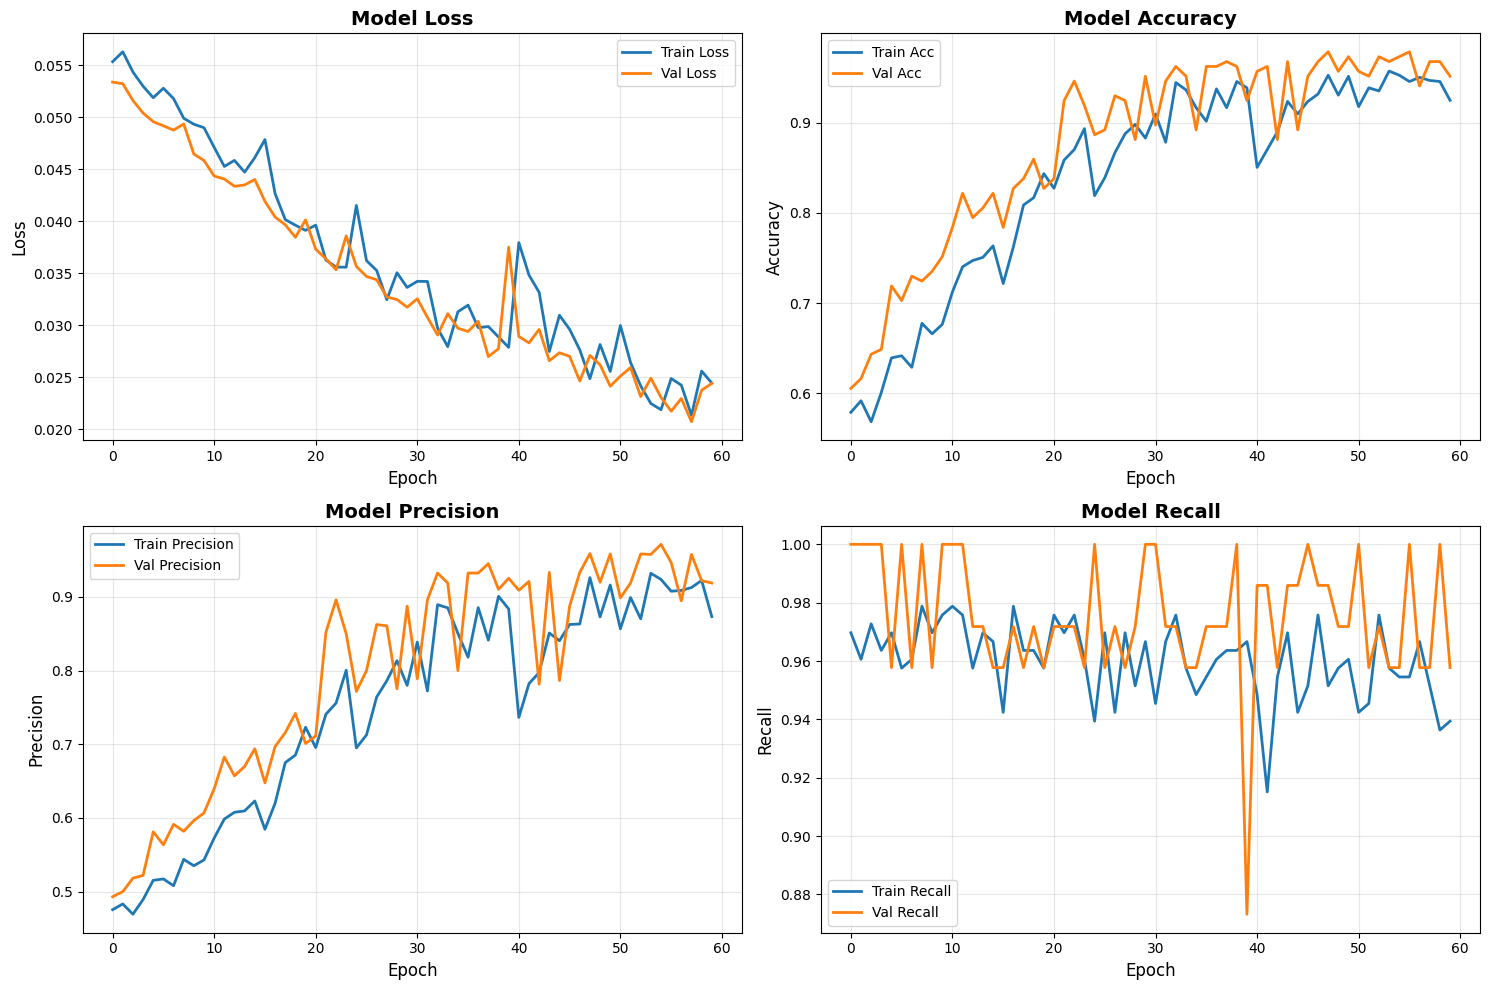

In [63]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Recall', fontsize=12)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# الحصول على probabilities
y_pred_prob = model.predict(X_test)

# تجربة thresholds مختلفة
thresholds = np.arange(0.1, 0.95, 0.05)  # وسّعنا المدى شوية
best_f1 = -1
best_thresh = 0.5
best_metrics = None

print("="*70)
print("TESTING DIFFERENT THRESHOLDS FOR BEST F1-SCORE")
print("="*70)
print(f"{'Thresh':<8} {'Prec':<8} {'Rec':<8} {'F1':<8} {'Pred_Pos':<10}")
print("-" * 70)

for t in thresholds:
    y_pred = (y_pred_prob >= t).astype(int)

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    pred_positive = y_pred.sum()

    print(f"{t:<8.2f} {precision*100:<8.2f} {recall*100:<8.2f} {f1*100:<8.2f} {pred_positive:<10}")

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t
        best_metrics = {
            'threshold': t,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'predicted_positive': int(pred_positive)
        }

# طباعة أفضل نتيجة (مضمونة ما يحصلش KeyError)
print("\n" + "="*70)
print("BEST THRESHOLD RESULT")
print("="*70)

if best_metrics is not None:
    bm = best_metrics
    print(f"Threshold        : {bm['threshold']:.3f}")
    print(f"Precision        : {bm['precision']*100:6.2f}%")
    print(f"Recall           : {bm['recall']*100:6.2f}%")
    print(f"F1-Score         : {bm['f1']*100:6.2f}%")
    print(f"Predicted Positive: {bm['predicted_positive']}")
else:
    print("تحذير: المودل لم يكتشف أي حالة إيجابية عند أي threshold!")
    print(f"أعلى احتمالية تنبؤ = {y_pred_prob.max():.4f}")

print("="*70)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
TESTING DIFFERENT THRESHOLDS FOR BEST F1-SCORE
Thresh   Prec     Rec      F1       Pred_Pos  
----------------------------------------------------------------------
0.10     38.38    100.00   55.47    185       
0.15     39.01    100.00   56.13    182       
0.20     39.44    100.00   56.57    180       
0.25     41.52    100.00   58.68    171       
0.30     47.33    100.00   64.25    150       
0.35     62.83    100.00   77.17    113       
0.40     78.89    100.00   88.20    90        
0.45     92.21    100.00   95.95    77        
0.50     97.26    100.00   98.61    73        
0.55     98.57    97.18    97.87    70        
0.60     100.00   92.96    96.35    66        
0.65     100.00   85.92    92.42    61        
0.70     100.00   77.46    87.30    55        
0.75     100.00   66.20    79.66    47        
0.80     100.00   49.30    66.04    35        
0.85     100.00   28.17    43.96    20        
0.90     100.00   12.68    22.50    9        

In [66]:
# استخدام أفضل threshold
y_pred_best = (y_pred_prob >= best_thresh).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

print("\n" + "="*60)
print(f"📊 CONFUSION MATRIX (threshold={best_thresh:.2f})")
print("="*60)
print(cm)
print()
print(f"True Negatives  (TN): {cm[0,0]:>4} - Correctly predicted as No Blink")
print(f"False Positives (FP): {cm[0,1]:>4} - Incorrectly predicted as Blink")
print(f"False Negatives (FN): {cm[1,0]:>4} - Missed Blinks")
print(f"True Positives  (TP): {cm[1,1]:>4} - Correctly detected Blinks")
print("="*60)

# Classification report
print("\n" + "="*60)
print("📋 DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_best, target_names=['No Blink', 'Blink']))


📊 CONFUSION MATRIX (threshold=0.50)
[[112   2]
 [  0  71]]

True Negatives  (TN):  112 - Correctly predicted as No Blink
False Positives (FP):    2 - Incorrectly predicted as Blink
False Negatives (FN):    0 - Missed Blinks
True Positives  (TP):   71 - Correctly detected Blinks

📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Blink       1.00      0.98      0.99       114
       Blink       0.97      1.00      0.99        71

    accuracy                           0.99       185
   macro avg       0.99      0.99      0.99       185
weighted avg       0.99      0.99      0.99       185



<Axes: >

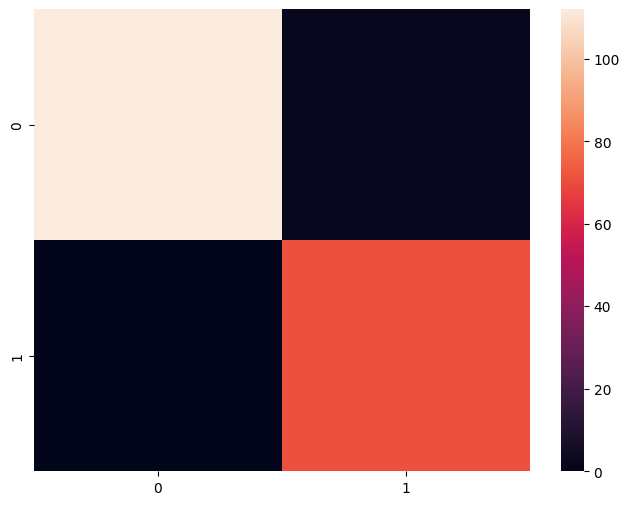

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm)

In [70]:
model.save("startle_blink_EEGNet_99_attention.keras")